## Lesson-06 Recurrent Neural Networks 循环神经网络的原理及应用

循环神经网络是我们常用的一个网络模型，这个网络能够处理例如字符串，时间序列等问题。因为模型对序列问题的优势，RNN模型已经成为了自然语言处理问题的常见方法。

在本课程的作业中，我们将完成三个任务：

0. 基于任务驱动，实际感受并能够初步使用pytorch；
1. 使用RNN模型进行名字的国籍分类；(这个程序主要是参考的Pytorch文档)

RNN也可以用于金融数据的预测，例如:
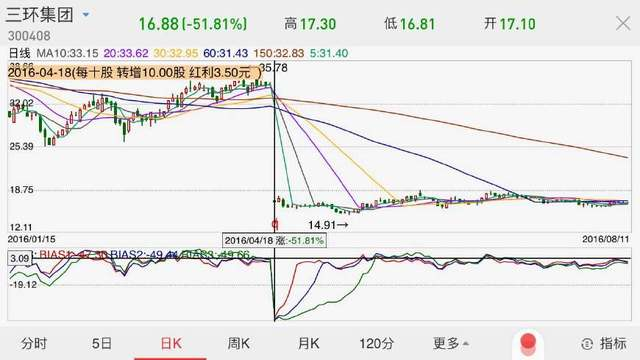

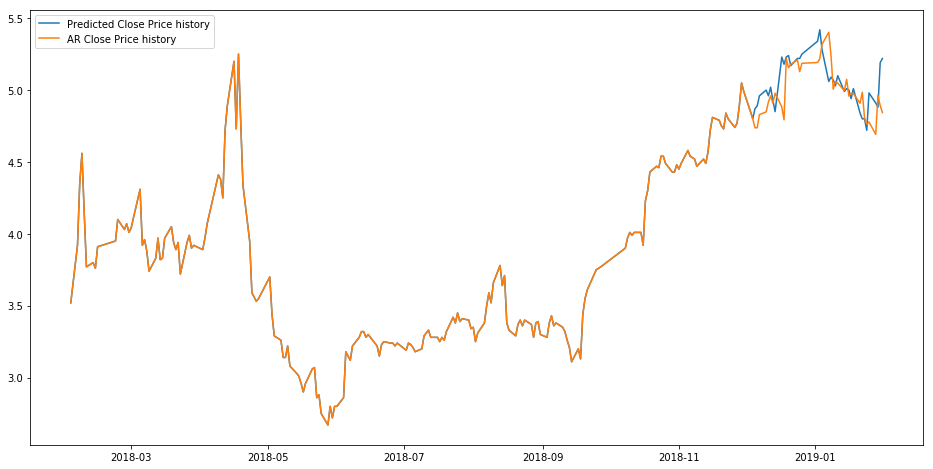

上图中蓝色的部分就是预测值， 关于RNN模型对金融数据的预测，我们只会会增加专门的研讨课程，给大家讲解

我们今天带给大家的是使用RNN进行名字的国籍分类:

## 1. 使用RNN模型进行名字的国籍分类

首先，我们下载数据: 将这个数据置于和我们jupyter notebook位置相同的地方

#### 1.1 我们利用通配符，打印出所有的文件

In [1]:
from io import open
import glob
import os
import matplotlib.pyplot as plt


def find_files(path): return glob.glob(path)

print(find_files('data/names/*.txt'))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


### 1.2 名字里边包含不少非Ascii码，为了简便问题，我们将他们转化为Ascii码

In [3]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

Slusarski


### Step1.3 然后我们建立类别和对于的名字的dictionary对应

In [4]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_2_Ascii(line) for line in lines]

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [5]:
n_categories

18

In [6]:
category_lines['Chinese'][:10]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao']

### 1.4 这一次我们使用pytorch, 来进行向量化

In [8]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_index('J'))

print(line_to_tensor('Jones').size())

35
torch.Size([5, 1, 57])


In [14]:
line_to_tensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

我们可以看到，是对名字里的每个字符做了 one-hot操作

### 1.5 然后，我们构建一个这样的RNN网络

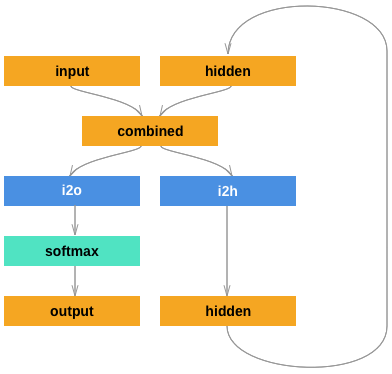

In [36]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128

In [37]:
rnn = RNN(n_letters, n_hidden, n_categories)

### 1.6 运行一步RNN

为了运行这个rnn网络，我们需要给他一个input，然后再加上一个hidden state. 然后我们就能过获得一个output，这个output便是的是这个单词的属于每个国家的概率，和接下来的hidden state.

In [38]:
input = letter_to_tensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [39]:
output

tensor([[-2.9296, -2.8483, -2.8172, -2.8860, -2.9340, -2.8602, -2.8457, -2.8559,
         -2.9278, -2.9443, -2.9367, -2.8389, -2.8713, -2.9621, -2.8844, -2.8984,
         -2.8481, -2.9555]], grad_fn=<LogSoftmaxBackward>)

In [40]:
next_hidden

tensor([[ 0.0242, -0.1116, -0.0037,  0.0634,  0.0147,  0.0505,  0.0381, -0.0881,
          0.0005,  0.0098,  0.0315,  0.0111, -0.1143,  0.0105,  0.0543, -0.0029,
         -0.0805, -0.0601, -0.0360,  0.0196, -0.0431,  0.0158, -0.0274, -0.0214,
          0.0353, -0.0878,  0.0054,  0.0177,  0.0276,  0.0985, -0.0206, -0.0157,
          0.1004,  0.0556, -0.0865, -0.0602,  0.0779, -0.0658, -0.0330,  0.0148,
         -0.0867, -0.0859,  0.0926, -0.0402,  0.0400, -0.1078,  0.0458,  0.0050,
          0.0212,  0.0125,  0.1235,  0.0319, -0.0191,  0.1295, -0.0481,  0.0026,
         -0.1250, -0.0648, -0.0303,  0.1215,  0.0449, -0.0341, -0.0124,  0.0239,
          0.0337, -0.0287,  0.0018,  0.0438,  0.1102,  0.1045, -0.0910, -0.0287,
         -0.0611, -0.0172, -0.0849, -0.0598,  0.0287, -0.0546, -0.0722,  0.1044,
         -0.0678,  0.0098,  0.0360,  0.0860, -0.0583,  0.1445, -0.0775,  0.0235,
         -0.1084, -0.0058, -0.0198, -0.0706,  0.1306, -0.0178, -0.0865,  0.0260,
          0.0050, -0.0190, -

然后，我们可以使用 line_to_tensor, 把一句话直接变成 tensor

In [22]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.7760, -2.8983, -2.9748, -2.9205, -3.0167, -2.9317, -2.8649, -2.8915,
         -2.7869, -2.8613, -2.9035, -2.9215, -2.9473, -2.9260, -2.8831, -2.7930,
         -2.9020, -2.8612]], grad_fn=<LogSoftmaxBackward>)


这个output，就是基于目前的RNN参数，预测出来的国籍概率分布。显然是不对的，因为里边的参数都是随机的。

### 1.7 更好的观察结果

为了能够更好的看到我们的训练结果，我们需要把输出的tensor变成我们能看懂的国籍

In [26]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i



对于刚刚产生的output，我们使用这个函数

In [27]:
print(category_from_output(output))

('Czech', 0)


### 1.8 随机生成训练数据

In [30]:
import random

def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning():
    category = sample(all_categories)
    line = sample(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = sample_trainning()
    print('category =', category, '/ line =', line)

category = French / line = Samson
category = Spanish / line = Chavez
category = Spanish / line = Pavia
category = Russian / line = Mahortov
category = Vietnamese / line = Ton
category = French / line = Vipond
category = Vietnamese / line = Mai
category = Portuguese / line = Pinheiro
category = Irish / line = Maciomhair
category = Korean / line = Koo


### 因为我们这个模型需要 softmax 来获得每个类别，所以我们使用cross-entropy作为Loss函数

In [41]:
criterion = nn.CrossEntropyLoss()

In [42]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [50]:
import time
import math

n_iters = 10000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 1s) 2.8417 O'Byrne / Italian ✗ (Irish)
1000 10% (0m 2s) 2.8176 Harb / Scottish ✗ (Arabic)
1500 15% (0m 4s) 2.7394 Demetrious / Greek ✓
2000 20% (0m 5s) 2.7313 Engel / German ✓
2500 25% (0m 7s) 2.5656 Sugihara / Japanese ✓
3000 30% (0m 8s) 2.9135 Soukup / Russian ✗ (Czech)
3500 35% (0m 10s) 2.3913 Winther / German ✓
4000 40% (0m 11s) 2.7710 Sokoloff / Czech ✗ (Polish)
4500 45% (0m 13s) 2.4369 O'Hagan / Irish ✓
5000 50% (0m 14s) 2.3377 Masi / Italian ✓
5500 55% (0m 16s) 3.1323 Burgstaller / Russian ✗ (German)
6000 60% (0m 17s) 2.8020 Douglas / Greek ✗ (Scottish)
6500 65% (0m 19s) 1.3075 Maslanka / Polish ✓
7000 70% (0m 20s) 2.4533 Bouchard / Dutch ✗ (French)
7500 75% (0m 21s) 2.5528 Cham / Chinese ✗ (Arabic)
8000 80% (0m 22s) 2.3828 Hulme / Arabic ✗ (English)
8500 85% (0m 24s) 2.2104 Rosario / Spanish ✗ (Portuguese)
9000 90% (0m 26s) 2.5104 Kishi / Polish ✗ (Japanese)
9500 95% (0m 28s) 2.2868 Rodagh / Irish ✓
10000 100% (0m 29s) 1.1395 Hadad / Arabic ✓


### 1.9 观察Loss的变化

In [51]:
all_losses

[2.8924706292152407,
 2.8775515484809877,
 2.870292899608612,
 2.8772067856788635,
 2.87020090341568,
 2.8735498118400575,
 2.8652635049819946,
 2.8542861223220823,
 2.857608036994934,
 2.8474227499961855,
 2.8470337128639223,
 2.8509806966781617,
 2.846759777069092,
 2.8230748701095583,
 2.8287533068656923,
 2.813158712387085,
 2.8299796557426453,
 2.8281653833389284,
 2.7981512093544008,
 2.8163255214691163,
 2.8072112727165224,
 2.7917881560325624,
 2.772860174179077,
 2.770077109336853,
 2.78889240026474,
 2.7660353779792786,
 2.7813345265388487,
 2.774310500621796,
 2.7409414863586425,
 2.7275892448425294,
 2.7551531839370726,
 2.720379021167755,
 2.7316614770889283,
 2.716980950832367,
 2.708627989292145,
 2.7158645248413085,
 2.714912486076355,
 2.7136244702339174,
 2.670642327070236,
 2.6980435109138488,
 2.6924266922473907,
 2.648427585363388,
 2.661674120426178,
 2.5708050417900083,
 2.656278563737869,
 2.5237321043014527,
 2.5867773342132567,
 2.6050904715061187,
 2.55699589

In [44]:
%matplotlib inline

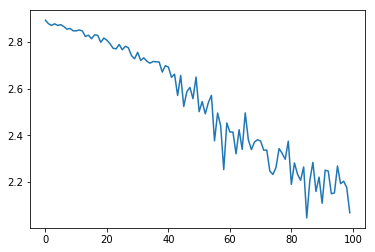

In [52]:
plt.plot(all_losses);

In [201]:
def evaluate(line_tensor, model):
    hidden = model.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output

def predict(input_line, model, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line), model)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky', rnn)
predict('Jackson', rnn)
predict('Satoshi', rnn)


> Dovesky
(-1.50) Polish
(-1.85) Russian
(-2.51) Scottish

> Jackson
(-1.75) Scottish
(-1.88) Russian
(-2.43) Polish

> Satoshi
(-1.70) Polish
(-1.77) Italian
(-2.25) Japanese


## 代码练习

>方便测试，把测试的代码封装成函数

In [162]:
def train_on_model(category_tensor, line_tensor, model, optimizer):
    hidden = model.initHidden()

    model.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    
    optimizer.step()
    # Add parameters' gradients to their values, multiplied by learning rate
    # for p in model.parameters():
    #   p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [163]:
def test(test_model, train_model, n_iters=10000, learning_rate=1e-3, printout=True, drawout=True):
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    optimizer = torch.optim.Adam(test_model.parameters(), lr=learning_rate)

    start = time.time()
    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = sample_trainning()
        output, loss = train_model(category_tensor, line_tensor, test_model, optimizer)
        current_loss += loss
        # Print iter number, loss, name and guess
        if printout and iter % print_every == 0:
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
    if drawout:
        plt.plot(all_losses);

### 1. 尝试在我们的RNN模型中添加更多layers，然后观察Loss变化

> 在combine后加入一个layer

In [74]:
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, comb_layer_size):
        super(RNN2, self).__init__()

        self.hidden_size = hidden_size
        
        self.combine_layer = nn.Linear(input_size + hidden_size, comb_layer_size)
        self.c2h = nn.Linear(comb_layer_size, hidden_size)
        self.c2o = nn.Linear(comb_layer_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        comb_l = self.combine_layer(combined)
        hidden = self.c2h(comb_l)
        output = self.c2o(comb_l)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
comb_layer_size = 64

In [199]:
criterion = nn.CrossEntropyLoss()

In [182]:
rnn2 = RNN2(n_letters, n_hidden, n_categories, comb_layer_size)

500 2% (0m 2s) 2.3764 O'Keeffe / Polish ✗ (Irish)
1000 5% (0m 4s) 1.7756 Bing / Chinese ✓
1500 7% (0m 7s) 2.2928 Hirota / Japanese ✓
2000 10% (0m 10s) 2.1633 Lieu / Korean ✗ (Vietnamese)
2500 12% (0m 12s) 2.9040 Naizer / German ✗ (Czech)
3000 15% (0m 15s) 1.5552 Cao / Vietnamese ✗ (Chinese)
3500 17% (0m 18s) 1.2732 Cameron / Scottish ✓
4000 20% (0m 22s) 0.8445 Tieu / Vietnamese ✓
4500 22% (0m 25s) 2.6977 Petit / French ✗ (Spanish)
5000 25% (0m 27s) 1.6059 Ruaidh / Irish ✓
5500 27% (0m 30s) 0.2362 Zielinski / Polish ✓
6000 30% (0m 32s) 2.3371 Sokoloff / Arabic ✗ (Polish)
6500 32% (0m 35s) 2.7114 Kock / Polish ✗ (German)
7000 35% (0m 37s) 1.5813 Nunes / Portuguese ✓
7500 37% (0m 39s) 2.3043 Lennon / Korean ✗ (Irish)
8000 40% (0m 41s) 1.6189 Jiang / Vietnamese ✗ (Chinese)
8500 42% (0m 43s) 1.6584 Wallace / French ✗ (Scottish)
9000 45% (0m 46s) 3.7600 Markytan / Korean ✗ (Czech)
9500 47% (0m 48s) 2.8701 Donoghue / Chinese ✗ (Irish)
10000 50% (0m 50s) 1.7284 Frederikson / Scottish ✗ (Englis

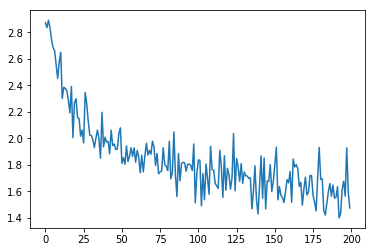

In [183]:
test(rnn2, train_on_model, n_iters=20000, learning_rate=0.001)

### 2. 将原始的RNN模型改成nn.LSTM和nn.GRU， 并且改变 `n_iters = 1000 ` 这个值，观察其变化

> LSTM:http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [174]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
    
    # 这里的hidden指(h_n, c_n)
    def forward(self, input, hidden):
        out, hidden = self.lstm(input.reshape(1, 1, self.input_size), hidden)
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out, hidden
    
    def initHidden(self):
        return (torch.zeros(self.n_layers, 1, self.hidden_size), torch.zeros(self.n_layers, 1, self.hidden_size))

In [184]:
lstm = LSTM(n_letters, n_hidden, n_categories, 1)

500 2% (0m 5s) 2.9680 Sokolowski / Russian ✗ (Polish)
1000 5% (0m 11s) 2.9026 De santigo / Korean ✗ (Portuguese)
1500 7% (0m 20s) 2.9618 Awad / Korean ✗ (Arabic)
2000 10% (0m 26s) 1.9919 Michalaras / Greek ✓
2500 12% (0m 32s) 2.1378 Sfakianos / Greek ✓
3000 15% (0m 37s) 2.9569 Abl / Chinese ✗ (Czech)
3500 17% (0m 43s) 2.7672 Mayer / French ✗ (German)
4000 20% (0m 49s) 2.9215 Yasui / Chinese ✗ (Japanese)
4500 22% (0m 54s) 2.5523 Abreu / Portuguese ✓
5000 25% (1m 0s) 2.8825 Kalogeria / Japanese ✗ (Greek)
5500 27% (1m 6s) 2.5938 Mendoza / Spanish ✓
6000 30% (1m 11s) 2.9677 Kappel / Arabic ✗ (Dutch)
6500 32% (1m 17s) 2.9459 Quinlivan / Irish ✗ (English)
7000 35% (1m 23s) 2.9169 Selmone / French ✗ (Italian)
7500 37% (1m 30s) 2.2849 Kosmatka / Polish ✓
8000 40% (1m 36s) 2.0063 Gomulka / Polish ✓
8500 42% (1m 43s) 2.7482 Johnston / Russian ✗ (Scottish)
9000 45% (1m 48s) 2.9670 Aitken / Arabic ✗ (Scottish)
9500 47% (1m 54s) 2.9803 Schneijders / Portuguese ✗ (Dutch)
10000 50% (2m 0s) 2.9774 Gov

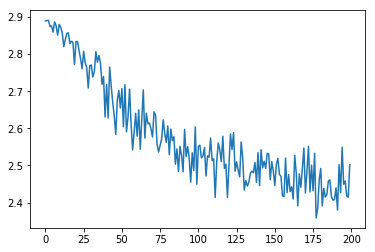

In [185]:
test(lstm, train_on_model, n_iters=20000, learning_rate=0.001)

In [168]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.gru = nn.GRU(input_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, input, hidden):
        out, hidden = self.gru(input.reshape(1, 1, self.input_size), hidden)
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out, hidden
    
    def initHidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

In [186]:
gru = GRU(n_letters, n_hidden, n_categories, 1)

500 2% (0m 5s) 2.8890 Mcdonald / Russian ✗ (Scottish)
1000 5% (0m 10s) 2.9225 Menendez / Irish ✗ (Spanish)
1500 7% (0m 16s) 1.9951 Banh / Vietnamese ✓
2000 10% (0m 22s) 2.9353 Aslam / Scottish ✗ (English)
2500 12% (0m 27s) 2.8831 Aggi / Vietnamese ✗ (Italian)
3000 15% (0m 32s) 2.4849 Fernandes / Portuguese ✓
3500 17% (0m 37s) 2.9626 Navrkal / Scottish ✗ (Czech)
4000 20% (0m 44s) 2.8628 Hassel / French ✗ (Dutch)
4500 22% (0m 49s) 2.9711 Marqueringh / Irish ✗ (Dutch)
5000 25% (0m 55s) 2.5017 Aritza / Spanish ✓
5500 27% (1m 0s) 2.7981 Marshall / French ✗ (Scottish)
6000 30% (1m 4s) 1.9821 Milionis / Greek ✓
6500 32% (1m 9s) 2.9805 Allcock / Polish ✗ (English)
7000 35% (1m 14s) 2.9804 Sneiders / Portuguese ✗ (Dutch)
7500 37% (1m 19s) 1.9902 Roach / Irish ✓
8000 40% (1m 24s) 1.9818 Manoukarakis / Greek ✓
8500 42% (1m 29s) 2.9798 Maneates / Portuguese ✗ (Greek)
9000 45% (1m 34s) 2.0107 Blanchet / French ✓
9500 47% (1m 39s) 1.9962 Morzhitsky / Russian ✓
10000 50% (1m 44s) 2.0413 Savatier / Fr

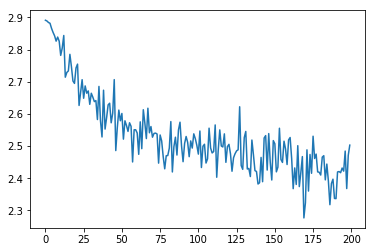

In [187]:
test(gru, train_on_model, n_iters=20000, learning_rate=0.001)

### 3. 把该RNN模型变成多层RNN模型，观察Loss的变化

> n_layers=2

In [188]:
gru2 = GRU(n_letters, n_hidden, n_categories, 2)

500 2% (0m 8s) 2.9587 Jamieson / Russian ✗ (Scottish)
1000 5% (0m 17s) 2.5470 Androsik / Czech ✗ (Russian)
1500 7% (0m 26s) 2.8454 Gwozdek / Russian ✗ (Polish)
2000 10% (0m 35s) 2.8038 Deeb / Chinese ✗ (Arabic)
2500 12% (0m 44s) 2.9766 Traverse / Arabic ✗ (French)
3000 15% (0m 53s) 2.0458 Chau / Vietnamese ✓
3500 17% (1m 2s) 2.8101 O'Hanlon / Polish ✗ (Irish)
4000 20% (1m 11s) 2.3870 Christodoulou / Greek ✓
4500 22% (1m 19s) 1.9864 Vu / Vietnamese ✓
5000 25% (1m 28s) 2.9671 Taylor / French ✗ (Scottish)
5500 27% (1m 37s) 2.9712 Fernandes / Arabic ✗ (Portuguese)
6000 30% (1m 45s) 2.9607 Ang / Korean ✗ (Chinese)
6500 32% (1m 54s) 2.9595 Ageevets / Greek ✗ (Russian)
7000 35% (2m 3s) 2.9197 Hoffman / Arabic ✗ (German)
7500 37% (2m 15s) 2.8794 Aswad / French ✗ (Arabic)
8000 40% (2m 28s) 2.9602 StrakaO / Polish ✗ (Czech)
8500 42% (2m 40s) 2.9792 Rademakers / Greek ✗ (Dutch)
9000 45% (2m 51s) 2.6884 Youj / Korean ✓
9500 47% (3m 3s) 2.9681 Kalb / Arabic ✗ (German)
10000 50% (3m 14s) 2.3503 Quig

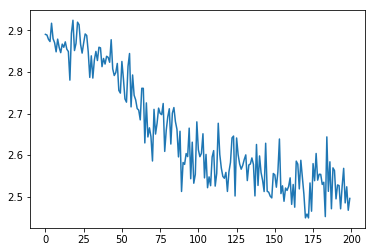

In [189]:
test(gru2, train_on_model, n_iters=20000, learning_rate=0.001)

### 4. Pytorch里边常用nn.NLLoss来代替crossentropy，将criterion改为nn.NLLoss，观察变化

> todo

In [190]:
criterion = nn.NLLLoss()

In [196]:
# NLL Loss需要用logsoftmax
class GRU2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(GRU2, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.gru = nn.GRU(input_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        out, hidden = self.gru(input.reshape(1, 1, self.input_size), hidden)
        out = self.fc(out[:, -1, :])
        out = self.logsoftmax(out)
        return out, hidden
    
    def initHidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

In [197]:
gru_ = GRU2(n_letters, n_hidden, n_categories, 2)

500 2% (0m 9s) 2.7075 Broz / Portuguese ✗ (Polish)
1000 5% (0m 20s) 1.6063 Meeuweszen / Dutch ✓
1500 7% (0m 29s) 1.1862 Shum / Korean ✗ (Chinese)
2000 10% (0m 37s) 0.1456 Okimasa / Japanese ✓
2500 12% (0m 46s) 1.5526 Romijn / English ✗ (Dutch)
3000 15% (0m 54s) 1.1211 Prinsen / Dutch ✓
3500 17% (1m 5s) 0.6549 Niemczyk / Polish ✓
4000 20% (1m 16s) 1.1046 Paredes / Spanish ✗ (Portuguese)
4500 22% (1m 27s) 1.5311 Ferguson / French ✗ (Scottish)
5000 25% (1m 37s) 2.5435 Kosko / Japanese ✗ (Czech)
5500 27% (1m 45s) 0.5549 Vo / Vietnamese ✓
6000 30% (1m 54s) 0.8025 Behrend / German ✓
6500 32% (2m 5s) 1.6593 Whalen / Dutch ✗ (Irish)
7000 35% (2m 17s) 1.5146 Vivas / Greek ✗ (Spanish)
7500 37% (2m 29s) 2.2133 Quinn / Vietnamese ✗ (Irish)
8000 40% (2m 37s) 2.6645 Koumans / Greek ✗ (Dutch)
8500 42% (2m 45s) 2.9472 Austin / French ✗ (English)
9000 45% (2m 54s) 1.2809 Luc / Chinese ✗ (Vietnamese)
9500 47% (3m 2s) 0.0026 Pantelakos / Greek ✓
10000 50% (3m 10s) 1.5611 Salazar / Arabic ✗ (Portuguese)
1

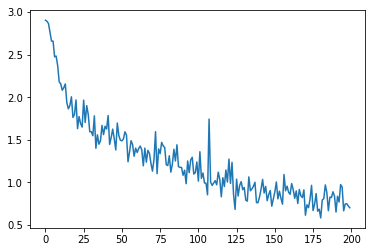

In [198]:
test(gru_, train_on_model, n_iters=20000, learning_rate=0.001)

In [203]:
predict('Jiang', rnn)
predict('Jiang', rnn2)
predict('Jiang', lstm)
predict('Jiang', gru)
predict('Jiang', gru2)
predict('Jiang', gru_)


> Jiang
(-1.90) Arabic
(-1.97) Vietnamese
(-2.15) Chinese

> Jiang
(-0.41) Vietnamese
(-1.81) Chinese
(-2.08) Korean

> Jiang
(1.00) Chinese
(0.00) Korean
(0.00) Italian

> Jiang
(0.99) Chinese
(0.00) Vietnamese
(0.00) German

> Jiang
(1.00) Chinese
(0.00) Korean
(0.00) Dutch

> Jiang
(-0.05) Chinese
(-3.46) Vietnamese
(-4.64) Korean


简单总结一下
>- 一开始调用lstm接口的时候遇到了input_shape的问题，后来研究了很多blog以及知乎帖子后发现，一般的做法是输入一个句子/词，在RNN模型里进行embedding。而此notebook里是每次输入一个字母的向量，结果就是少了batchsize这个维度，reshape一下就解决了。其实如果在test里不对一个名字的每个单词进行for loop计算，直接输入batch * length size的input，也不会导致这个问题。但是为了保持前后一致性，就没有在这一点进行修改了。
- 因为没有对数据进行训练集和测试集的切分，所以没评价不同的RNN模型的效果如何。但是单单从中文名'Jiang'来看，lstm和gru比普通的RNN模型效果好很多